<div class="usecase-title">Spotting areas for public transportation planning in City of Melbourne</div>

<div class="usecase-authors"><b>Authored by: </b> Tithra Chap</div>

<div class="usecase-duration"><b>Duration:</b> 120 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<div class="usecase-section-header">Scenario</div>

The City of Melbourne has always evolved, and so have the numbers of its residential dwellings and employment population (based on data available on Melbourne Open Data). Without a consistent or parallel increase of off-street parking, the city will face the difficulty in providing enough spaces for parking of private transportation. To resolve this problem, the city planner needs to locate the potential areas where extension of public transportation should be implemented to replace the need for off-street parking. CLUE datasets contain information of employment, residential dwellings and parking spots of the city blocks. By tracking down the number of employments and residential dwellings in the city blocks and analyze their consistent trends with number of off-street parkings, we can identify the potential blocks that a city planner should pay more attention and ensure that public transportation are sufficient to handle the daily commuting traffic. 

<div class="usecase-section-header">What this use case will teach you</div>

This case study is intended to provide educational instructions of how to use CLUE datasets (Employment by blocks, Residential dwellings by blocks, and Off-street parking by blocks) to resolve the above analytical problem.

The key learnings are:

- How to explore the CLUE datasets using *pandas profiling*
- How to clean those CLUE datasets
- How to build linear regression model for this use case
- How to use *ipywidgets* & *bninteract* to implement interactivity
- How to link visualization with *ipywidgets*

NOTE: This use case provides interactive tools so that user can experience the interaction with the data, as well as learning how to use the data.

<div class="usecase-section-header">Walkthrough steps:</div>

1. Explore the THREE datasets
2. Clean and merge them
3. Build analysis model
4. Visualize the analytical results
5. Develop interactivity

<div class="usecase-section-header">A brief introduction to CLUE data</div>

The City of Melbourne conducts a comprehensive bi-annual survey of its residents and businesses called the "Census of Land Use and Employment (CLUE)". CLUE captures key information on land use, employment, and economic activity across the City of Melbourne.

CLUE data assists the City of Melbourne's business planning, policy development and strategic decision making. Investors, consultants, students, urban researchers, property analysts, businesses and developers can take advantage of CLUE to understand customers, the marketplace and the changing form and nature of the city.

Among many CLUE datasets, this use case employs THREE datasets available at Melbourne Open Data website:

- [Residential Dwellings Dataset 2002-2020](https://data.melbourne.vic.gov.au/Property/Residential-dwellings/44kh-ty54)
- [Employment by city blocks 2002-2020](https://data.melbourne.vic.gov.au/Business/Employment-by-block-by-CLUE-industry/b36j-kiy4)
- [Off-street car parking 2002-2020](https://data.melbourne.vic.gov.au/Transport/Off-street-car-parks-with-capacity-and-type/krh5-hhjn)

[CLUE blocks](https://data.melbourne.vic.gov.au/Business/Blocks-for-Census-of-Land-Use-and-Employment-CLUE-/aia8-ryiq) json map is also used for location visualization.

NOTE: we suggest scanning through data dictionaries of the above datasets at Melbourne Open Data to familiarize yourself beforehand.

<div class="usecase-section-header">Detail Walkthrough:</div>

<div class="usecase-section-header">1. Explore the datasets</div>

Datasets containing missing values, duplications, inconsistency, extreme outliers are common problems in real world data. One of the most convenient way to identify these issues is to profile the data using python package ***pandas-profiling***. An example below shows how to read a .csv dataset and generate an html file containing deep profiling detail of ***Residential Dwelling.csv*** of CLUE dataset.

In [1]:
import pandas as pd
#Residential dwellings data
resident = pd.read_csv('https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/residential-dwellings/exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true',on_bad_lines='skip',delimiter=";")
resident = resident[resident["census_year"] != 2021]
resident.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177730 entries, 0 to 188159
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   census_year       177730 non-null  int64  
 1   block_id          177730 non-null  int64  
 2   property_id       177730 non-null  int64  
 3   base_property_id  177730 non-null  int64  
 4   building_address  177730 non-null  object 
 5   clue_small_area   177730 non-null  object 
 6   dwelling_type     177730 non-null  object 
 7   dwelling_number   177730 non-null  int64  
 8   longitude         174861 non-null  float64
 9   latitude          174861 non-null  float64
 10  location          174861 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 16.3+ MB


<div class="usecase-section-header">2. Clean and merge the datasets</div>


CLUE datasets are mainly clean, although there are some issues with missing values and duplicated records. The process below is done to eliminate these problems, and drop unnecessary columns.


### Residential Dwellings dataset

In [2]:
#Total records before cleaning
print('Total records before cleaning is',len(resident))
#Data cleaning (remove duplicated values)
resident.drop_duplicates(inplace = True)
#Total records after cleaning
print('Total records after cleaning is',len(resident))
#Select only necessary columns
selected_columns =['census_year','block_id','clue_small_area','dwelling_number']
resident = resident[selected_columns]
#Sum the [Dwelling number] based on [Block ID] and [Census Year], but keep one [CLUE small area] for each Block ID
resident_by_block = resident.groupby(['census_year','block_id']).agg({'clue_small_area':'max','dwelling_number':'sum'})
print('Total records after grouping (by Block ID) is',len(resident_by_block))
#Detail of the residential dwellings by block
resident_by_block.head()


Total records before cleaning is 177730
Total records after cleaning is 177730
Total records after grouping (by Block ID) is 8036


clue_small_area  dwelling_number
census_year block_id                                  
2002        11        Melbourne (CBD)               97
            12        Melbourne (CBD)              189
            13        Melbourne (CBD)              113
            14        Melbourne (CBD)               87
            15        Melbourne (CBD)              282

As the result, we obtain ***resident_by_block*** pandas-series containing 2 columns: "CLUE small area" and "Dwelling number", with "Census year" and "Block ID" as multiple index.

We repeat similar codes to work on *Employment by city blocks* and *Off-street car parking* datasets below:

### Employment by city blocks datasets

In [3]:
employment = pd.read_csv("https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/employment-by-block-by-anzsic/exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true",delimiter=";")
#Total records before cleaning
print('Total records before cleaning is',len(employment))
#Cleaning the data (remove missing values at [Total employment in block])
employment.dropna(subset=['total_jobs_in_block'],inplace=True)
#Total records after cleaning
print('Total records after cleaning is',len(employment))
#Select only necessary columns
selected_columns =['census_year','block_id','total_jobs_in_block']
employment = employment[selected_columns]
#Sum the employment based on Block ID and Year
employment_by_block = employment.groupby(['census_year','block_id']).sum()
print('Total records after grouping (by Block ID) is',len(employment_by_block))
#Detail of the employment_by_block
employment_by_block.head()

Total records before cleaning is 11788
Total records after cleaning is 9232
Total records after grouping (by Block ID) is 9232


total_jobs_in_block
census_year block_id                     
2002        0                    319729.0
            1                         6.0
            2                       169.0
            4                      1174.0
            5                        12.0

### Off-street car parking datasets

In [4]:
#Off-street parking data
parking = pd.read_csv('https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/off-street-car-parks-with-capacity-and-type/exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true',delimiter=";")
#Total records before cleaning
print('Total records before cleaning is',len(parking))
#Data cleaning (remove duplicate values)
parking.drop_duplicates(inplace=True)
#Total records after cleaning
print('Total records after cleaning is',len(parking))
#Select only necessary columns
selected_columns =['census_year','block_id','parking_spaces']
parking = parking[selected_columns]
#Sum the parking based on Block ID and Year
parking_by_block = parking.groupby(['census_year','block_id']).sum()
print('Total records after grouping (by Block ID) is',len(parking_by_block))
#Detail of the employment_by_block
parking_by_block.head()

Total records before cleaning is 129657
Total records after cleaning is 129657
Total records after grouping (by Block ID) is 10496


parking_spaces
census_year block_id                
2002        1                    270
            6                    500
            11                   303
            12                   749
            13                   622

### Merge the clean datasets and plot the scattered distributions

The scatter plots provide insight of linear relationship between dependent variable (Off-street car park) and independent variables (Residential Dwellings , Employment by city block). Learning from this relationship, we can notice whether there is unhealthy distribution that could imply insufficient off-street car parking in the city blocks.

                      clue_small_area  dwelling_number  total_jobs_in_block  \
census_year block_id                                                          
2002        11        Melbourne (CBD)               97                733.0   
            12        Melbourne (CBD)              189               3113.0   
            13        Melbourne (CBD)              113               1673.0   
            14        Melbourne (CBD)               87               2519.0   
            15        Melbourne (CBD)              282               2553.0   

                      parking_spaces  
census_year block_id                  
2002        11                   303  
            12                   749  
            13                   622  
            14                  1229  
            15                    88  


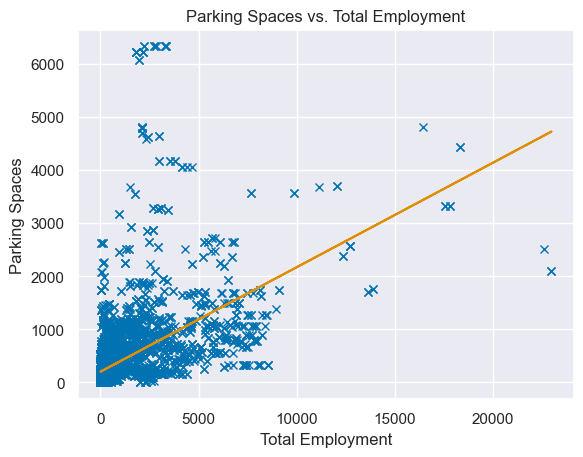

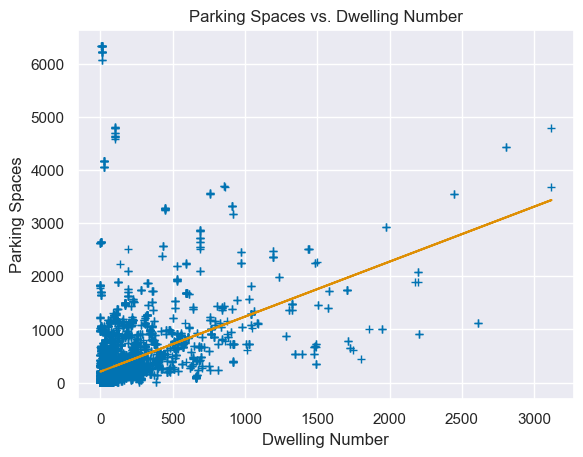

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)
sns.set_palette('colorblind')

#Combine the datasets (only take the blocks that match between three datasets)
data = resident_by_block.merge(employment_by_block, left_index= True, right_index=True)
data = data.merge(parking_by_block,left_index=True,right_index=True)
print(data.head())
#Prepare data for scatter plots
x1 = data['total_jobs_in_block']
x2 = data['dwelling_number']
y = data['parking_spaces']
#Plot the data points (Parking Spaces vs. Total Employment) and regression line
plt.plot(x1,y,'x')
a, b = np.polyfit(x1,y,1)
plt.plot(x1, a*x1 + b)
plt.title('Parking Spaces vs. Total Employment')
plt.ylabel('Parking Spaces')
plt.xlabel('Total Employment')
plt.show()
#Plot the data points (Parking Spaces vs. Dwelling Number) and regression line
plt.plot(x2,y,'+')
a, b = np.polyfit(x2,y,1)
plt.plot(x2, a*x2 + b)
plt.title('Parking Spaces vs. Dwelling Number')
plt.ylabel('Parking Spaces')
plt.xlabel('Dwelling Number')
plt.show()

#NOTE: This dataset here ('data') need to be exported to GitHub and named as "merged_data.csv" to allow interactive (function) to work

We can notice the distributions below the orange lines (regression lines) are likely to have insufficient car parking.

<div class="usecase-section-header">3. Build analysis model</div>

This model uses multiple-variable linear regression. The model has dependent variable ***Y*** as "Off-street car park" and ***X1***, ***X2*** as "Residential Dwellings" and "Employment by city block" respectively.

### Prepare the data for model training

In [20]:
#Prepare X and Y data for model training
def Get_data(Data, Year_to_include,Employment,Resident_dwellings):
  import numpy as np
  features = np.array(['total_jobs_in_block', 'dwelling_number'])
  features_to_include = features[[Employment,Resident_dwellings]] #Define the data features for the study
  data_to_include = Data.loc[min(Year_to_include):max(Year_to_include)] #Get the wanted rows
  X = np.array(data_to_include[features_to_include]) #Get the independent variable(s) based on the selected features
  Y = np.array(data_to_include['parking_spaces']) #Get the dependent variable
  return X, Y
#print('The study period is between: %d and %d'%(min(years_to_include),max(years_to_include)))


### Build linear regression model

In [7]:
def lm_model(X, Y):
  import sklearn
  from sklearn import linear_model
  from sklearn.ensemble import IsolationForest
  iso = IsolationForest(contamination=0.1)#use outliers detector
  yhat = iso.fit_predict(X) #Search for outliers
  lm = linear_model.LinearRegression() #linear regression model
  lm.fit(X[yhat!=-1],Y[yhat!=-1]) # Train the model excluding outliers
  return lm

### Predict the parking problem based on the latest year (2020)

In [24]:
#Predict parking issue in 2020
def Get_predict_result(Data, Model, Employment, Residential_dwellings):
  import numpy as np
  data_latest = Data.loc[years.max] # Get data of 2020
  features = np.array(['total_jobs_in_block', 'dwelling_number'])
  features_to_include = features[[Employment,Residential_dwellings]] #Define the data features for the study
  result = np.round(Model.predict(np.array(data_latest[features_to_include]))) #Predict based on the selected features
  data_latest['Predict_parking'] = result.astype(int) #Add result to the data
  impact = result - data_latest['parking_spaces']
  impact[impact>=0] = 100*(impact[impact>=0]/(max(impact[impact>=0]))) # Normalize the impact index (0-100)
  data_latest['Impact_index'] = impact.astype(int) #Add impact index to the data
  return data_latest

<div class="usecase-section-header">4. Visualize the analytical results</div>

### Plot barchart of the predict results

In [9]:
#visualize the impacted city blocks
def bar_plot(Data, Impact_level):
  import matplotlib.pyplot as plt
  import numpy as np
  import seaborn as sns
  sns.set_theme(color_codes=True)
  #Only visualize the blocks greater than the impact level
  plot_data = Data['Impact_index']#Get only the data records with higher impact level
  plt.figure(figsize=(13,len(plot_data)/3))
  plt.xlabel('Impact Index (Higher index indicates serious shortage of off-street parking)')
  plt.ylabel('Block ID of Melbourne city')
  plt.title('Impacted Blocks vs. Impact Index\n Shows impact index from '+str(Impact_level)+' to 100')
  plt.barh (plot_data.index.astype(str),plot_data.values)
  plt.show()

### Plot the map using Folium Choropleth

In [34]:
def plot_map(clue_data):
  import json
  import folium
  #Load the csv and json data for map plotting
  json_file = open('interactive_dependencies/clue_blocks.geojson') 
  clue_geo = json.load(json_file)

  clue_data.reset_index(inplace=True) #turn the index (Block_ID) into a column in the dataframe (clue_data)
  clue_data['block_id'] = clue_data['block_id'].astype(str) # conver [Block ID] to str, so that it is compatible with json content

  #Create the initial map
  fmap = folium.Map(location=[-37.811600, 144.964610],
            tiles = 'Stamen Toner',
            width = '70%',
            height = '100%',
            zoom_start=13)

  #create the choropleth layer and add to the map above
  choropleth = folium.Choropleth(
      geo_data=clue_geo,
      name='choropleth',
      data=clue_data,
      columns=['block_id','Impact_index'],
      key_on='feature.properties.block_id',
      fill_color='YlOrRd',
      fill_opacity=1,
      line_opacity=0.5,
      nan_fill_color='cloud',
      nan_fill_opacity = 0.2,
      highlight=True,
      legend_name='Impact index'
  ).add_to(fmap)

  #Add more layers and tooltips
  choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['block_id','clue_area'],labels=True))
  return fmap

<div class="usecase-section-header">5. Develop interactivity</div>

To have interactivity on Python notebook online, we need third party server to compile the Python notebook codes. In the replacement of local Jupyter notebook engine (used for locally run the Python notebook), Binder server provides that free service for Jupiter notebook community. What you need to do is:
1. Create a public GitHub account
2. Store your Python notebook file there
3. Install nbinteract in your Jupyter notebook environment (pip install nbinteract)
4. On Jupyter notebook commandline, change drive to GitHub clone folder (where your Python notebook located)
5. run "nbinteract init" to create "requirements.txt" to tell Binder server the dependencies your Python notebook needs
6. run "nbinteract YourNotebookFile.ipynb" to create "YourNoteFile.html"

This [demonstration tutorial](https://www.youtube.com/watch?v=jln6h-dE2-0) provides more insight of the *nbinteract*.

### Build interactive widgets using ipywidget

In [11]:
#Create a widget to select the range of study years
import ipywidgets as widgets
style = {'description_width': 'initial'} #for long label of the widgets
#Year-to-include slider
years = widgets.IntRangeSlider(value=[2002, 2020], min=2002, max=2020, step=1, description='Years to include:', style=style)
#Display option: impact level
show_impact = widgets.IntSlider(value=15, min=10, max=100, step=1, description='Impact index from:',style=style)
#Employment checkbox
chk_employment = widgets.Checkbox(value=True, description='Employment', indent=False)
#Residential Dwellings checkbox
chk_resident = widgets.Checkbox(value=True, description='Residential Dwellings', indent=False )


### Main function for interactivity

In [12]:
#Define function to execute when using interactive tools
def show_interaction(Year_to_include,Employment,Residential_dwellings, Impact_level):
    from IPython.display import display
    #Must import libraries and datasets for a self-contain function
    import pandas as pd
    import warnings
    warnings.filterwarnings("ignore") #suppress dataframe warning

    data = pd.read_csv('interactive_dependencies/merged_data.csv') #the dataset that contains all the THREE features (employment, resident & parking)
    data = data.rename(columns={"Census year": "census_year","Block ID": "block_id","CLUE small area":"clue_small_area","Dwelling number":"dwelling_number","Total employment in block":"total_jobs_in_block","Parking spaces":"parking_spaces"})
    data.set_index(['census_year','block_id'],inplace=True) #Turn the data to pandas series
    print('='*23)
    print('|DATA ANALYSIS RESULTS|')
    print('='*23)
    print('(NOTE: The city blocks without parking information available are ignored by our analyzing model.)\n\n')
    if (not(Employment)) & (not(Residential_dwellings)):
        Employment = True  #Prevent both data features are unticked ==> Error
    #Get the filtered data for analysis
    X, Y = Get_data(data,Year_to_include,Employment,Residential_dwellings)
    #Build regression model
    lm = lm_model(X,Y)
    #Get the predicted results
    predict_results = Get_predict_result(data,lm, Employment, Residential_dwellings)
    predict_results = predict_results[predict_results['Impact_index']>=Impact_level] #only plot city block that have higher impact level

    #Plot the barchart of the predicted results
    bar_plot(predict_results, Impact_level);
    #Show table of the impacted blocks in detail table
    print('\n\n The table below shows the impacted blocks (limited parking) by the order of the impact index.\n')
    display(predict_results.sort_values('Impact_index',ascending = False))
    #Plot the folium choropleth map
    print('The impacted city blocks can be seen via the map here:')
    display(plot_map(predict_results))

<div class="usecase-section-header">Demo use case</div>

With interactivity, a city planner can try to spot the city blocks that are likely to have insufficient parking but having high density of employments and residential dwellings. Underneath the code block below, there are interactivity options that can be selected to analyze the data.

>Interactivity options:
- ***Years to include*** - Determines the census data (in year) to be included in the analysis
- ***Employment check*** - Ticked to include "Employment by city block" dataset in the analysis
- ***Residential Dwellings check*** - Ticked to include "Residential Dwellings" dataset in the analysis
- ***Impact index from*** - Filter out the block areas that have minor parking insufficient problem (lower than the selected ***Impact index***)

Once all options have been selected, please click on "Start Analysis..." button to analysis the data.

NOTE: If both ***Employment*** and ***Residential Dwellings*** are unchecked, ***Employment*** will be automatically used for analysis. 

In [ ]:
#Display the interactive tools
from ipywidgets import interact_manual
interact_manual.opts['manual_name'] = 'Start Analyzing'
interact_manual(show_interaction, Year_to_include=years, Employment=chk_employment, Residential_dwellings = chk_resident, Impact_level = show_impact);

interactive(children=(IntRangeSlider(value=(2002, 2020), description='Years to include:', max=2020, min=2002, …